# Replication

Research paper is focussed on the solution of `linear ill-posed inverse problems` in `image processing`. 
- [Non-local Regularization of Inverse Problems v2011](https://bougleux.users.greyc.fr/articles/PeyreBougleuxCohen11.pdf)
- [Non-local Regularization of Inverse Problems v2015](https://hal.archives-ouvertes.fr/hal-00419791v1/document)

## Brief Introduction to Theory

The paper is focussed on solution of `linear ill-posed inverse problem` in `image processing`.

`Inverse problems` as opposed to `direct problems` are `ill-posed` in the sense of Hadamard. As direct problems are `well-posed` according to work of Hadamarad[1902]. These three properties satisfied by `well-posed`, existence of a solution, uniqueness of solution and stability. 

Equations for which ( at least ) one of these properties does not hold are called `ill-posed`. eg. Cauchy's problem for Laplace equation.

Here the requirement of stability is the most important one (See Courant, Hilbert 1962) i.e solution depends continously on the data. If a problem lacks the property of stability, then its solution is practically impossible to compute because any measurement or numerical computation is polluted by unavoidable errors.

Briefly, as Lanczos put it, 
> Lack of information cannot be remedied by any mathematical trickery

## Simulate noise

Gaussian white noise with a standard deviation of $0.02||u||_∞$

The function takes a signal u as input and returns an ndarray which is an image with added noise.


In [2]:
from PIL import Image

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

path_to_image = 'len_std.jpg'

def load_image_as_gray(path_to_image):
    img = matplotlib.image.imread(path_to_image)
    # ITU-R 601-2 luma transform (rgb to gray)
    img = np.dot(img,[0.2989 , 0.5870 , 0.1140])
    return img

image = load_image_as_gray(path_to_image)

image = Image.fromarray(image)
image = image.resize((64, 64))
image = np.array(image)
H, W = image.shape[0], image.shape[1]
n = H*W

In [28]:
from numpy import random

def masking(img, percentage):
    indices = random.choice(img.shape[0], size=int(img.shape[0]*percentage), replace=False, p=None)
    b = np.zeros((H,W)).ravel()
    for ind in indices:
        b[ind] = img[ind]
    return b, indices

# percentage to keep
percentage = 0.2
image_with_noise, indices = masking(image.ravel(), percentage)
image_with_noise = image_with_noise.reshape((H,W))

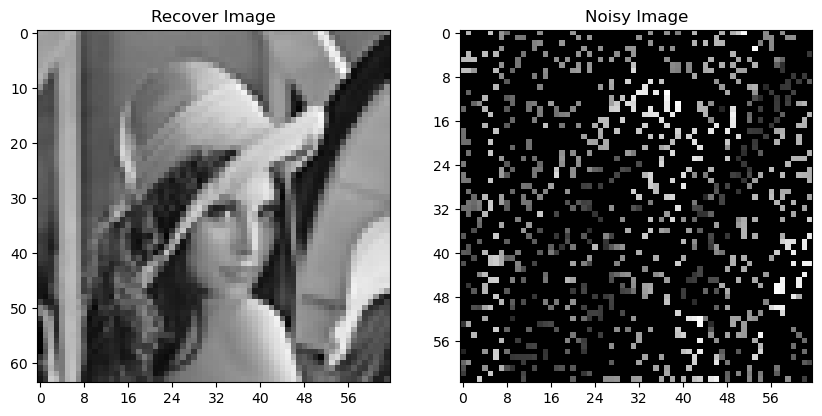

In [29]:
# To display images
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))

# Plot the first image in the first subplot
ax1.imshow(image, cmap='gray')
ax1.set_title('Recover Image')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
ax1.set_xticks(range(0, 64, 8))
ax2.set_yticks(range(0, 64, 8))

# Display the original image and the noisy image superimposed in red color
ax2.imshow(image_with_noise, cmap='gray')

ax2.set_title('Noisy Image')

# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
ax2.set_xticks(range(0, 64, 8))
ax2.set_yticks(range(0, 64, 8))

# Show the figure
plt.show()

In [ ]:
# Gaussian White Noise

import numpy as np

def simulate_noise(u):
  noise = 0.02 * np.linalg.norm(u, ord=np.inf)
  
  # Debugging
  # print("Type of Noise", type(noise), noise.shape)
  
  # Add noise to input signal
  image_with_noise = add_noise(u, noise)
  # Convert from float to uint8
  image_with_noise = np.array(image_with_noise, dtype="uint8")
  return image_with_noise

def add_noise(u, noise):
  return u + noise

### Load and display image with noise

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image = Image.open('len_std.jpg')

# Resize the image to 256x256 pixels
image = image.resize((256, 256))

# Convert the image to grayscale
image = image.convert('L')

# Convert the image to a NumPy array
image_array = np.array(image)

# Add Gaussian white noise with standard deviation 0.02||u||∞ to the image
# Does noise have to randomly distributed ?
image_with_noise = simulate_noise(image_array)

# To display images
# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot the first image in the first subplot
ax1.imshow(image, cmap='gray')
ax1.set_title('Recover Image')
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
ax1.set_xticks(range(0, 256, 50))
ax2.set_yticks(range(0, 256, 50))

# Display the original image and the noisy image superimposed in red color
ax2.imshow(image_with_noise, cmap='gray')

ax2.set_title('Noisy Image')

# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
ax2.set_xticks(range(0, 256, 50))
ax2.set_yticks(range(0, 256, 50))

# Show the figure
plt.show()

## 3.2 Extract patch and Patch Local Signatures

A local signature of dimension $q ≤ τ^2$ is obtained from patch using an orthogonal projector $U ∈ ℝ^{q 𝚡 τ^2}$ in our case (14,25) which can be checked with U.shape 

Also the orthogonal projector has to satisfy the condition $UU^* = Id$. 
The condition $UU* = Id$ means that the product of the matrix U with its conjugate transpose is equal to the identity matrix. This condition is important because it ensures that the projection preserves the norm of the patches. If the projection did not preserve the norm, the patches would be distorted after the projection.

This reduces the dimensionality from 25 to 14, as given in the paper. Also it is suggested to reduce the signature_dimension which is 14, to a lower value for faster processing but not too good results.

In [30]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d

def extract_patches(image, patch_size):
    """
    Extract patches of a given size from an image.
    
    Parameters:
        image (ndarray): 2D array representing the image.
        patch_size (int): Size of patches in pixels.
        
    Returns:
        ndarray: Array of patches with shape (num_patches, patch_size, patch_size).
    """
    # Extract patches from the image
    patches = extract_patches_2d(image, (patch_size, patch_size))
    return patches

def compute_projector(patches, signature_dimension, num_random_patches=500):
    """
    Compute the orthogonal projector using the q leading PCA eigenvectors of random patches.
    
    -> See Section 3.2

    Parameters:
        patches (ndarray): Array of patches with shape (num_patches, patch_size, patch_size).
        signature_dimension (int): Dimensionality of local signatures.
        num_random_patches (int, optional): Number of random patches to use to compute the orthogonal projector. Default is 500.
        
    Returns:
        ndarray: Orthogonal projector with shape (signature_dimension, num_random_patches).
    """
    # Select random patches to compute the orthogonal projector
    num_patches = len(patches)
    random_indices = np.random.choice(num_patches, size=num_random_patches, replace=False)
    random_patches = patches[random_indices]
    # Fit a PCA model to the random patches
    pca = PCA(n_components=signature_dimension)
    pca.fit(random_patches.reshape(num_random_patches, -1))
    # Extract the q leading PCA eigenvalues as the orthogonal projector
    U = pca.components_
    # Iteratively adjust the values in the matrix U until the condition UU* = Id is satisfied
    I = np.eye(signature_dimension)
    while np.abs(U @ U.T - I).sum() > 1e-6:
      U = (U + U.T) / 2

    return U

def reduce_dimensionality(patches, signature_dimension):
    """
    Compute the orthogonal projector using the q leading PCA eigenvalues of random patches as the orthogonal projector
    and extract the local signature of a patch using the orthogonal projector.

    See Section 3.2

    Parameters:
        patch (ndarray): Array of the patch with shape (patch_size, patch_size).
        signature_dimension (int): Dimensionality of local signatures.
    
    Returns:
        ndarray: Local signature of the patch with shape (signature_dimension,).
    """
    # Compute the orthogonal projector using the compute_projector function
    U = compute_projector(patches, signature_dimension)


    # Initialize empty array to store local signatures
    signatures = np.empty((signature_dimension, len(patches)))

    for i, patch in enumerate(patches):
      # Reduce the dimensionality of the patch and extract its local signature
      signature = U @ patch.flatten()
      # signature = reduce_dimensionality(patch, signature_dimension)
      # Store the local signature as a column in the signatures array
      signatures[:, i] = signature
      # Extract the local signature of the patch using the orthogonal projector
    
    return signatures

### Testing and Debugging

In [58]:
# Debugging

patches = extract_patches(image_with_noise, 1)
print(patches.shape)


# Compute the orthogonal projector using the q=14 leading PCA eigenvectors of the patches and reduce dimensionality
signature_dimension = 1
# proj = compute_projector(patches, signature_dimension, num_random_patches=500)
signatures = reduce_dimensionality(patches, signature_dimension)

# The shape of set of signature should be q x n 
print(signatures.shape)

(4096, 1, 1)
(1, 4096)


## 3.3 Graph Based Priors on Images

A non local graph is a set of weights $w$ = {$w_{x,y}$}$_{x,y}$ with  
1. each pair of pixel a weight $w_{x,y} ≥ 0$, $\Sigma_{y}w_{x,y}=1$
1. and, $∥x-y∥ > ρ ⇒ w_{x,y} = 0$ 

The parameter ρ controls the degree of non-locality of the graph and is set to 15 pixels.

$J_w(f) = Σ_{∥x - y∥ ≤ ρ} w_{x,y}∥p_x(f) - p_y(f)∥$. To solve for this use section 3.2. 

This non-local functional or energy is a vectorial $l^1$ norm. See Section 4.1

In [32]:
#Import math Library
import numpy as np
import math


# Patch Variation ||px(f) - py(f)|| used in non-local regularization functional Jw(f)
# Correct the usage of Patch and its calculation in the patch_variation
# def patch_variations(patch):
#   # Using l2 norm
#   patch_var = np.linalg.norm(patch, ord=1)
#   return patch_var

# Calculate set of weights

def create_non_local_graph(image, radius):
    """
    Create a non-local graph for an image with weights w_{x,y} for each pair of pixels (x, y).
    
    Parameters:
        image (ndarray): 2D array representing the image.
        radius (int): Radius of non-locality. Pairs of pixels (x, y) with ||x-y|| > radius have w_{x,y} = 0.
    
    Returns:
        ndarray: 2D array of weights with shape (num_pixels, num_pixels).
    """
    # Get dimensions of the image
    M, N = image.shape
    
    # Initialize array to store weights
    weights = np.zeros((M*N, M*N))
    
    # Iterate over pairs of pixels (x, y)
    for x in range(M):
        for y in range(N):
            for i in range(M):
                for j in range(N):
                    # Calculate distance between pixels (x, y) and (i, j)
                    distance = np.sqrt((x - i)**2 + (y - j)**2)
                    # If distance is greater than the radius, set w_{x,y} = 0
                    if distance > radius:
                        weights[x*N + y, i*N + j] = 0
                    else:
                        # Set w_{x,y} to a positive value
                        weights[x*N + y, i*N + j] = 1
    
    # Normalize weights so that each row has a sum of 1
    weights /= weights.sum(axis=1, keepdims=True)
    
    return weights

import numpy as np

# def create_non_local_graph(image, radius):
#     """
#     Create a non-local graph for an image with weights w_{x,y} for each pair of pixels (x, y).
    
#     Parameters:
#         image (ndarray): 2D array representing the image.
#         radius (int): Radius of non-locality. Pairs of pixels (x, y) with ||x-y|| > radius have w_{x,y} = 0.
    
#     Returns:
#         ndarray: 2D array of weights with shape (num_pixels, num_pixels).
#     """

#     # Get dimensions of the image
#     M, N = image.shape

#     # Get the indices of the pixels
#     x, y = np.indices((M, N))

#     # Calculate distance between each pair of pixels
#     distance = np.sqrt((x.ravel()[:, np.newaxis] - x.ravel()[np.newaxis, :])**2 + (y.ravel()[:, np.newaxis] - y.ravel()[np.newaxis, :])**2)

#     # Create a weight matrix by setting all weights to 0 if distance is greater than the radius, otherwise set it to 1
#     weights = np.where(distance <= radius, 1, 0)

#     # Normalize weights so that each row has a sum of 1
#     weights /= weights.sum(axis=1, keepdims=True)

#     return weights


def calculate_cost_function(weights, patches, radius):
    """
    Calculate the cost function J_w(f) for a set of weights w_{x,y} and a function f.
    
    Parameters:
        weights (ndarray): 2D array of weights with shape (num_pixels, num_pixels).
        f (ndarray): 2D array representing the function f with shape (num_pixels, num_pixels).
        patch_size (int): Size of patches in pixels.
        radius (int): Radius for non-local graph.
    
    Returns:
        float: Cost function J_w(f).
    """
    cost = 0

    # Get the number of patches
    num_patches = len(patches)
    
    # Iterate over pairs of patches (x, y)
    for x in range(num_patches):
        for y in range(num_patches):
            # Calculate patch distance using l1 vectorial norm
            patch_distance = np.linalg.norm(patches[x] - patches[y])
            # If patch distance is within the radius, add w_{x,y} * patch distance to the cost
            if patch_distance <= radius:
                cost += weights[x, y] * patch_distance
    
    return cost

### Testing and Debugging

**This crashes with error**



In [37]:
# Create a non-local graph for an image with radius 15 pixels

# Calculate cost function for a set of weights and a function

#Calculate weights
weights = create_non_local_graph(image_with_noise, 7)
# Get Patches
cost = calculate_cost_function(weights, patches, radius=7)

In [55]:
weights

array([[0.02222222, 0.02222222, 0.02222222, ..., 0.        , 0.        ,
        0.        ],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.        , 0.        ,
        0.        ],
       [0.01694915, 0.01694915, 0.01694915, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01694915, 0.01694915,
        0.01694915],
       [0.        , 0.        , 0.        , ..., 0.01923077, 0.01923077,
        0.01923077],
       [0.        , 0.        , 0.        , ..., 0.02222222, 0.02222222,
        0.02222222]])

In [38]:
weights.shape

(4096, 4096)

## 3.4 Maximum Entropy Prior on the Graph Weights

The constraint $w \in C$ is not strong enough to select an efficient graph to process an image. Therefore, we force the graph energy $E(w)$

$E(w) = Σ_{x,y}w_{x,y}log(w_{x,y})$

In [35]:
import numpy as np

def calculate_graph_energy(weights):
    """
    Calculate the graph energy E(w) for a set of weights w_{x,y}.
    
    Parameters:
        weights (ndarray): 2D array of weights with shape (num_pixels, num_pixels).
    
    Returns:
        float: Graph energy E(w).
    """
    energy = 0

    # Iterate over pairs of pixels (x, y)
    for x in range(weights.shape[0]):
        for y in range(weights.shape[1]):
            # Calculate w_{x,y} * log(w_{x,y}) and add to energy
            energy += weights[x, y] * np.log(weights[x, y])
    
    return energy

### Testing and Debugging

**This is dependent on graph weight, due to lack of resources crashing the runtime** 

In [40]:
# Not needed to be tested separately
# First calculate the weight non-local graph
# weights = create_non_local_graph(image_with_noise, 3)
# Pass the returned to calculate energy
energy = calculate_graph_energy(weights)

C:\Users\Ahmed Abouslima\AppData\Local\Temp\ipykernel_7252\1927613116.py:19: RuntimeWarning: divide by zero encountered in log
  energy += weights[x, y] * np.log(weights[x, y])
C:\Users\Ahmed Abouslima\AppData\Local\Temp\ipykernel_7252\1927613116.py:19: RuntimeWarning: invalid value encountered in double_scalars
  energy += weights[x, y] * np.log(weights[x, y])


In [41]:
energy

nan

# 4 About Non-Local Regularization 

If an optimization problem is separately convex with respect to $f$ and $w$, it means that the objective function of the optimization problem is convex with respect to each of the variables $f$ and $w$ when the other variable is fixed.

That is optimization problem has a unique global minimum when each variable is optimized independently. Therefore it is coordinate descent algorithm is used to optimize the graph $w$ and then the image $f$ to recover.

Moreover, if the optimization problem is not jointly convex in $(f, w)$, it means that the objective function is not convex with respect to both variables simultaneously. This means that the optimization problem may not have a unique global minimum when both variables are optimized together. Instead, there may be multiple local minima, and the optimization algorithm may get stuck in a local minimum rather than finding the global minimum.


## 4.1 Non-Local Patch Operator

> TODO: Need refining 
- Use mapping functions required for pixel domain to signature domain
- Use the returned values from the relevant functions to calculate non-local energy which is a vectorial $l^1$ norm of $J_w(f) = ∥G_wPf∥_1$

- `signature-valued gradient` maps signatures in $P$ to signature domain $D$
- `signature differential` is returned by `signature_differential` function.
- The adjoint of the `signature-valued gradient` is called `signature-valued divergence`
- The above two provide the value for $G_w$ and $G^*_w$


In [42]:
# Signature differential is calculate using $d_{x,y} = w_{x,y}(p_x - p_y)$ over two patches
def signature_differential(patch1, patch2, weight):
    """
    Calculate the signature differential between two patches.
    
    Parameters:
        patch1 (ndarray): 1D array representing the first patch.
        patch2 (ndarray): 1D array representing the second patch.
        weight (float): Weight to be applied to the signature differential.
    
    Returns:
        ndarray: Signature differential between the two patches.
    """
    differential = weight * (patch1 - patch2)
    return differential

# Calculate l1 and l_inf norm of signature differential 
def signature_differential_norm(patch1, patch2, weight):
    """
    Calculate the l1 norm and infinity norm of the signature differential between two patches.
    
    Parameters:
        patch1 (ndarray): 1D array representing the first patch.
        patch2 (ndarray): 1D array representing the second patch.
        weight (float): Weight to be applied to the signature differential.
    
    Returns:
        tuple: Tuple containing the l1 norm and infinity norm of the signature differential between the two patches.
    """
    differential = signature_differential(patch1, patch2, weight)
    l1_norm = np.abs(differential).sum()
    infinity_norm = np.abs(differential).max()
    return l1_norm, infinity_norm

# Calc adjoint of signature_valued_differential this is called signature-valued divergence
def signature_differential_adjoint(d, q=14, r=15):
    n = d.shape[1]
    p = np.empty((n, q))
    for x in range(n):
        for y in range(n):
            if np.abs(x - y) <= r:
                p[x] += d[:, y] - d[:, x]
    return p

## 4.2 Optimization on the Graph Equation 14

Although, in my understanding the functions defined in this notebook in `3.3 and 3.4` together will lead to $w(f)$. Then weight update in algorithm should function how with respect to the two functionals referred to.

If, f is fixed, optimizing the $f^*$ `eq(9)` with respect to $w$ defines an optimal graph $w(f)$ `eq(14)`.

$Z_x = Σ_y w̃_{x,y}$

In [46]:
import random

# To be used for weight update step
def gamma_parameter(f, tau=5):
    """
    To calculate gamma parameter using the formula tau * infinity norm of f divided by 10
    """
    gamma = tau * np.linalg.norm(f, ord=np.inf) / 10
    return gamma

# The normalizing constant $Z_x$ is calculated by summing over the values of $w̃_{x,y}$ for all possible values of $y$
def calc_normalizing_constant(weight, patches):
    """
    Calculate the normalizing constant for a single weight and a set of patches.

    Parameters:
      weight (float): Weight value.
      patches (ndarray): 3D array of patches, with shape (num_patches, patch_size, patch_size).

    Returns:
      float: Normalizing constant.
    """
    num_patches = patches.shape[0]
    normalizing_constant = 0
    for x in range(num_patches):
        normalizing_constant += weight
    return normalizing_constant


# To compute patch variation ||p_x(f) - p_y(f)||
def calc_patch_variation(px, py):
    """
    The function calculates patch variation of two patches
    passed to it as arguments

    Parameters:
    px: patch
    py: patch

    Returns:
    float: Patch variation
    """
    pv = np.linalg.norm(px - py)
    return pv

# Update weights
def update_weight(patches, gamma, orthogonal_projector):
    """
    To update weights in the algorithm step

    Returns:
    weight
    """
    # Get two random patch
    pie_x, pie_y = random_patch_picker(patches)

    # Reduce dimensionality of both
    px = reduce_patch_dimensionality(pie_x, orthogonal_projector)
    py = reduce_patch_dimensionality(pie_y, orthogonal_projector)

    # Get patch variation between the patches picked
    patch_variation = calc_patch_variation(px, py)

    # Calculate weight 
    w_tilde = math.exp(patch_variation/gamma)

    # Calculate Normalizing Constant
    normalizing_constant = calc_normalizing_constant(w_tilde, patches)

    # Calculate $w(f)_{x,y}$ i.e equation 14 for weight update
    w_f = w_tilde/ normalizing_constant 
    return w_f

# Helper that returns two patches
def random_patch_picker(patches):
    """
    Pick two random patches from the patches
    """

    # Choose two random indices from the array
    x = random.randint(0, patches.shape[0] - 1)
    y = random.randint(0, patches.shape[0] - 1)
    # Return the patches at the chosen indices
    return patches[x], patches[y]

def reduce_patch_dimensionality(patch, projector):
    """
    Reduce the dimensionality of a patch using an orthogonal projector.

    Parameters:
      patch (ndarray): 2D array representing the patch.
      projector (ndarray): 2D array representing the orthogonal projector.

    Returns:
      ndarray: 2D array representing the patch with reduced dimensionality.
    """
    # Flatten the patch into a 1D array
    patch_flat = patch.flatten()
    # Project the patch onto a lower-dimensional space using the orthogonal projector
    reduced_patch_flat = projector @ patch_flat
    # Reshape the projected patch into a 2D array
    reduced_patch = reduced_patch_flat.reshape(patch.shape)
    return reduced_patch

## 4.3 Optimization on the Image Equation 16, 17

If w is fixed, optimizing $f^*$ `eq(9)` defines an optimal image $f(w)$ `eq(15)`. This is done using a first-order scheme of `forward-backward splitting`

In [47]:
## TODO: need Clarification 

## 4.4 Computation of Proximal Operator

In [48]:
## TODO: need Clarification 

### Test and Debugging

In [49]:
# def proximal_correction(f_tilde, w, gamma):
#   # Compute the gradient of the graph regularization term
#   graph_gradient = graph_based_prior_gradient(f_tilde, w, gamma)

#   # Perform the proximal correction using forward-backward splitting
#   f_new = f_tilde - tau * graph_gradient
#   f_new = projection(f_new)

#   return f_new


# Algorithm

## ALGORITHM: Setup

- Extract patches from noise-free image to calculate Orthogonal Projector
- Extract patches from noisy image to use as input aka measured data to algorithm

In [54]:
# Patch Size in pixels
patch_size = 5

# Size of Signature
signature_dimension = 14

# Calculated using noise-free image
gamma = gamma_parameter(image,5)

# Patches from noisy image
patches = extract_patches(image, patch_size)

# Extract patches from the noise-free image
patches_without_noise = extract_patches(image, 5)

# Calculate Orthogonal Projector U used in (11)
orthogonal_projector = compute_projector(patches_without_noise, 14)

# TODO:
# tolerance f
# tolerance d

ValueError: operands could not be broadcast together with shapes (14,25) (25,14) 

In [ ]:
import numpy as np

# Needs to be cleaned up 
# Especially the arguments
# And the iterations need cleaning up as well

def recover_image(u, Phi, P, G, lambda_, gamma, tau, q, rho, tolf, told, max_iter, nu, eta):
  """
  Block coordinate descent algorithm to minimize equation (9)

  Parameters:
    u: measured data
    phi:
    gamma:
    tau:
    rho:
    tolf:
    told:
    max_iter:
    P:
    G:
  
  Return:
    f_star: recovered image
  """
    # Initialization
    # This  may be wrong algorithm
    # f = image_with_noise
    f = Phi*u 
    converged = False
    iter_count = 0
    
    while not converged:

        # Weight update
        # Patches has to updated every iteration also
        w = update_weight(f, patches, gamma, orthogonal_projector)
        
        # Image update
        f_prev = f
        l = 0

        # TODO: Fix
        while True:
            # Gradient descent
           # f_tilde = f - (1/lambda_) * (Phi @ (Phi.T @ f - u) + P.T @ (P @ f - w))
            f_tilde = f + nu*Phi.T (u - Phi.T @ f)
            # Proximal correction
            d_prev = 0 # TODO: initialization should match the dimensions of the image
            k = 0
            while True:
                # Gradient descent
                omega = nu*lambda_
                d_tilde = d_prev + eta * G @ P ((f_tilde / omega) - P.T @ G.T @ d_prev)
                # Projection
                # TODO: Fix completley
                d = d_tilde / np.maximum(1, np.abs(d_tilde))
                if np.linalg.norm(d - d_prev) < told:
                    break
                d_prev = d
                k += 1
            #f = f_tilde - (1/gamma) * P.T @ (G @ d)
            f = f_tilde - omega * P.T @ (G.T @ d)
            if np.linalg.norm(f - f_prev) < tolf:
                break
            f_prev = f
            l += 1
        
        # Check convergence
#         if np.linalg.norm(f - f_prev) < tolf or iter_count >= max_iter:
#             converged = True
#         iter_count += 1

    
    return f


## PSNR to Evaluate results

PSNR(f ⋆ , f ) = −20 $log2 (∥ f^⋆ − f ∥/∥ f ∥_∞ )$

where f* and f are the two images being compared, "∥.∥" is the L2 norm, and $||.||_∞$ is the infinity norm. The PSNR value is returned in decibels (dB).

The distance is calculated using the `L2 norm`, which is defined as the square root of the sum of the squares of the differences between the elements of the two images. In other words, it is a measure of the overall difference between the two images, taking into account the values of all pixels in the images. The `L1 norm`, on the other hand, is defined as the sum of the absolute values of the differences between the elements of the two images. It is a measure of the overall difference between the two images, but it only takes into account the magnitude of the differences and not the sign.

The numerator of the PSNR formula is the Euclidean distance between the two images, which is typically computed using the l2 norm. The l2 norm is defined as the square root of the sum of the squares of the elements of the image matrix, and is commonly used to calculate distances in image processing. On the other hand, the l1 norm is defined as the sum of the absolute values of the elements of the image matrix, and is not typically used to calculate distances in image processing. Therefore, it is reasonable to assume that the numerator of the PSNR formula uses the l2 norm.

In [ ]:
import numpy as np

def psnr(f_star, f):
    """Calculate the PSNR between two images.

    Parameters
    ----------
    f_star : numpy.ndarray
        The recovered image.
    f : numpy.ndarray
        The original image.

    Returns
    -------
    float
        The PSNR between the two images.
    """

    # Ensure that the images have the same dtype and shape
    assert f_star.shape == f.shape, \
        "Reference and distorted images must have the same shape"
    assert f_star.dtype == f.dtype, \
        "Reference and distorted images must have the same dtype"
    # If it is l2 norm instead of l1 change the ord=2 
    numerator = np.linalg.norm(f_star - f, ord=1)
    denominator = np.linalg.norm(f, ord=np.inf)
    return -20 * np.log2(numerator / denominator)

# Numerical Experiments

## 5 Numerical Experiments

## 5.1 Inpainting

In [ ]:
## Pass value of phi from here
## Trigger the algorithm

## 5.2 Super-Resolution

In [ ]:
# Calculate the dual operator and pass it to the algorithm
import numpy as np

def dual_operator(g):
    """
    Compute the dual operator Φ*g for the super-resolution inverse problem.
    
    Parameters:
        g (ndarray): Input image of shape (p,).
    
    Returns:
        ndarray: Output image of shape (n,).
    """
    # Upsample the input image by a factor of 8
    n = 8 * len(g)
    g = np.repeat(g, 8)
    
    # Define the Gaussian kernel with standard deviation 6 pixels
    h = np.exp(-np.arange(-3, 4)**2 / (2 * 6**2))
    h = h / h.sum()
    
    # Convolve the upsampled image with the kernel
    g = np.convolve(g, h, mode='same')
    
    return g

# TODO:
# Call the algorithm function

## 5.3 Compressive-Sampling

In [ ]:
from scipy.linalg import hadamard
import numpy as np

def fast_sampling_operator(f, p):
  """
  Computes the fast sampling operator for compressive sensing.
  
  Parameters:
      f (ndarray): Input signal in R^n.
      p (int): Number of samples to select.
      
  Returns:
      ndarray: Fast sampling operator applied to f in R^p.
  """
  n = f.shape[0]
  P1 = np.random.permutation(n)
  P2 = np.random.permutation(n)
  H = hadamard(n)
  return (P1 @ H @ P2 @ f)[:p]

## TODO:
## Call the algorithm function

## Replication Results

In [ ]:
## TODO: Compare the PSNR